In [2]:
import pandas as pd
from src.models.model_trainer_rl_v3 import ModelTrainerRL, TradingEnvRL
from src.utils.config_loader import load_config

# Load configuration
config = load_config("config/config.yaml")

In [ ]:


# Load and prepare data
data = pd.read_csv('data/processed/CWCO_processed_2022.csv')
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

# Split into train/test
split_idx = int(len(data) * 0.7)
df_train = data.iloc[:split_idx].copy()
df_test = data.iloc[split_idx:].copy()

# Initialize trainer
trainer = ModelTrainerRL(config['reinforcement_learning'])

# Prepare environments (handles feature scaling automatically)
env_train, env_test = trainer.prepare_environment(
    df_train, 
    df_test, 
    reward_func="profit"  # or "profit", "sortino", "cvar", "max_drawdown"
)

# Train PPO only
print("Training PPO...")
result = trainer.train_ppo(env_train)
model = result["model"]
print("Training Complete!")

# Evaluate with multiple seeds (recommended)
seeds = [42, 43, 44]
metrics_agg = trainer.evaluate_over_seeds(model, env_test, seeds, algorithm="PPO")

print("\n--- Multi-Seed Evaluation Results ---")
print(f"Total Return: {metrics_agg['total_return']['mean']:.2%} ± {metrics_agg['total_return']['ci95']}")
print(f"Sharpe Ratio: {metrics_agg['sharpe_ratio']['mean']:.3f} ± {metrics_agg['sharpe_ratio']['ci95']}")
print(f"Sortino Ratio: {metrics_agg['sortino_ratio']['mean']:.3f} ± {metrics_agg['sortino_ratio']['ci95']}")
print(f"Max Drawdown: {metrics_agg['max_drawdown']['mean']:.2%} ± {metrics_agg['max_drawdown']['ci95']}")

# Single run evaluation (if you only want one)
metrics_single = trainer.evaluate_model(model, env_test, algorithm="PPO", seed=42)
print("\n--- Single Run Evaluation ---")
print(f"Total Return: {metrics_single['total_return']:.2%}")
print(f"Sharpe Ratio: {metrics_single['sharpe_ratio']:.3f}")

# Save the model and artifacts
trainer.save_models("models/ppo_artifacts")

# Use model for inference (generate actions on new data)
obs, _ = env_test.reset(seed=42)
done = False
actions = []
while not done:
    action, _ = model.predict(obs, deterministic=True)
    actions.append(float(action[0]))
    obs, _, terminated, truncated, _ = env_test.step(action)
    done = terminated or truncated

print(f"\nGenerated {len(actions)} trading actions")

Config loaded successfully
RL Config: {'algorithms': ['ppo', 'a2c', 'ddpg', 'td3', 'sac'], 'environment': {'initial_balance': 100000, 'commission': 0.001, 'lookback_window': 60, 'reward_function': 'sharpe'}, 'ppo': {'total_timesteps': 200000, 'learning_rate': 0.0002, 'n_steps': 2048, 'batch_size': 128, 'gamma': 0.99, 'gae_lambda': 0.95, 'ent_coef': 0.05}, 'a2c': {'total_timesteps': 200000, 'learning_rate': 0.0003, 'n_steps': 20, 'gamma': 0.99, 'ent_coef': 0.01, 'max_grad_norm': 0.5}, 'ddpg': {'total_timesteps': 150000, 'learning_rate': 0.0001, 'buffer_size': 100000, 'batch_size': 128, 'gamma': 0.99, 'tau': 0.005}, 'td3': {'total_timesteps': 150000, 'learning_rate': 0.0003, 'buffer_size': 100000, 'batch_size': 256, 'gamma': 0.99, 'tau': 0.005, 'policy_delay': 2}, 'sac': {'total_timesteps': 150000, 'learning_rate': 0.0003, 'buffer_size': 100000, 'batch_size': 256, 'gamma': 0.99, 'tau': 0.005, 'ent_coef': 'auto'}, 'dqn': {'total_timesteps': 200000, 'learning_rate': 0.0001, 'buffer_size': 

C:\Users\BOOKLAPTOP\AppData\Local\Temp\ipykernel_39672\3796917067.py:23: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])


Data shape: (927, 39)
Columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits', 'sma_20', 'sma_50', 'rsi_14', 'macd_12_26_9', 'macdh_12_26_9', 'macds_12_26_9', 'bbl_5_2.0_2.0', 'bbm_5_2.0_2.0', 'bbu_5_2.0_2.0', 'bbb_5_2.0_2.0', 'bbp_5_2.0_2.0', 'vwap_d', 'roc_1', 'atrr_14', 'tsi_13_25_13', 'tsis_13_25_13', 'adx_14', 'adxr_14_2', 'dmp_14', 'dmn_14', 'cci_20_0.015', 'rolling_high_52w', 'rolling_low_52w', 'fibo_23.6', 'fibo_38.2', 'fibo_50.0', 'fibo_61.8', 'fibo_78.6', 'fibo_100.0', 'fibo_161.8', 'future_return', 'label']
Date range: 2022-03-15 00:00:00-04:00 to 2025-11-20 00:00:00-05:00
Train set: 648 days (2022-03-15 00:00:00-04:00 to 2024-10-10 00:00:00-04:00)
Test set: 279 days (2024-10-11 00:00:00-04:00 to 2025-11-20 00:00:00-05:00)
Training env observation space: Box(-inf, inf, (36,), float32)
Training env action space: Box(-1.0, 1.0, (1,), float32)
Scaler fitted: True
Training PPO Agent...


d:\MSDS\buy-sell-hold-strategy-prediction\venv-3.11\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


✓ Training Complete!
Running evaluation across 3 seeds...

MULTI-SEED EVALUATION RESULTS
Total Return:   240.39% ± [2.403937636913948, 2.403937636913948]
Sharpe Ratio:     5.042 ± [5.041536785725754, 5.041536785725754]
Sortino Ratio:    8.398 ± [8.397794076132726, 8.397794076132726]
Max Drawdown:    -8.88% ± [-0.08881699409882414, -0.08881699409882414]

Single Run Evaluation (Seed=42)...

SINGLE RUN EVALUATION
Total Return:  240.39%
Final Value:   $340,393.76
Sharpe Ratio:  5.042
Sortino Ratio: 8.398
Max Drawdown:  -8.88%
Avg Reward:    122.4933

Generating trading actions on test set...
✓ Generated 218 trading actions
Action range: [-1.000, 1.000]
Action mean: 0.259
Actions breakdown:
  Long (>0.5):  131
  Neutral (-0.5 to 0.5): 15
  Short (<-0.5): 72


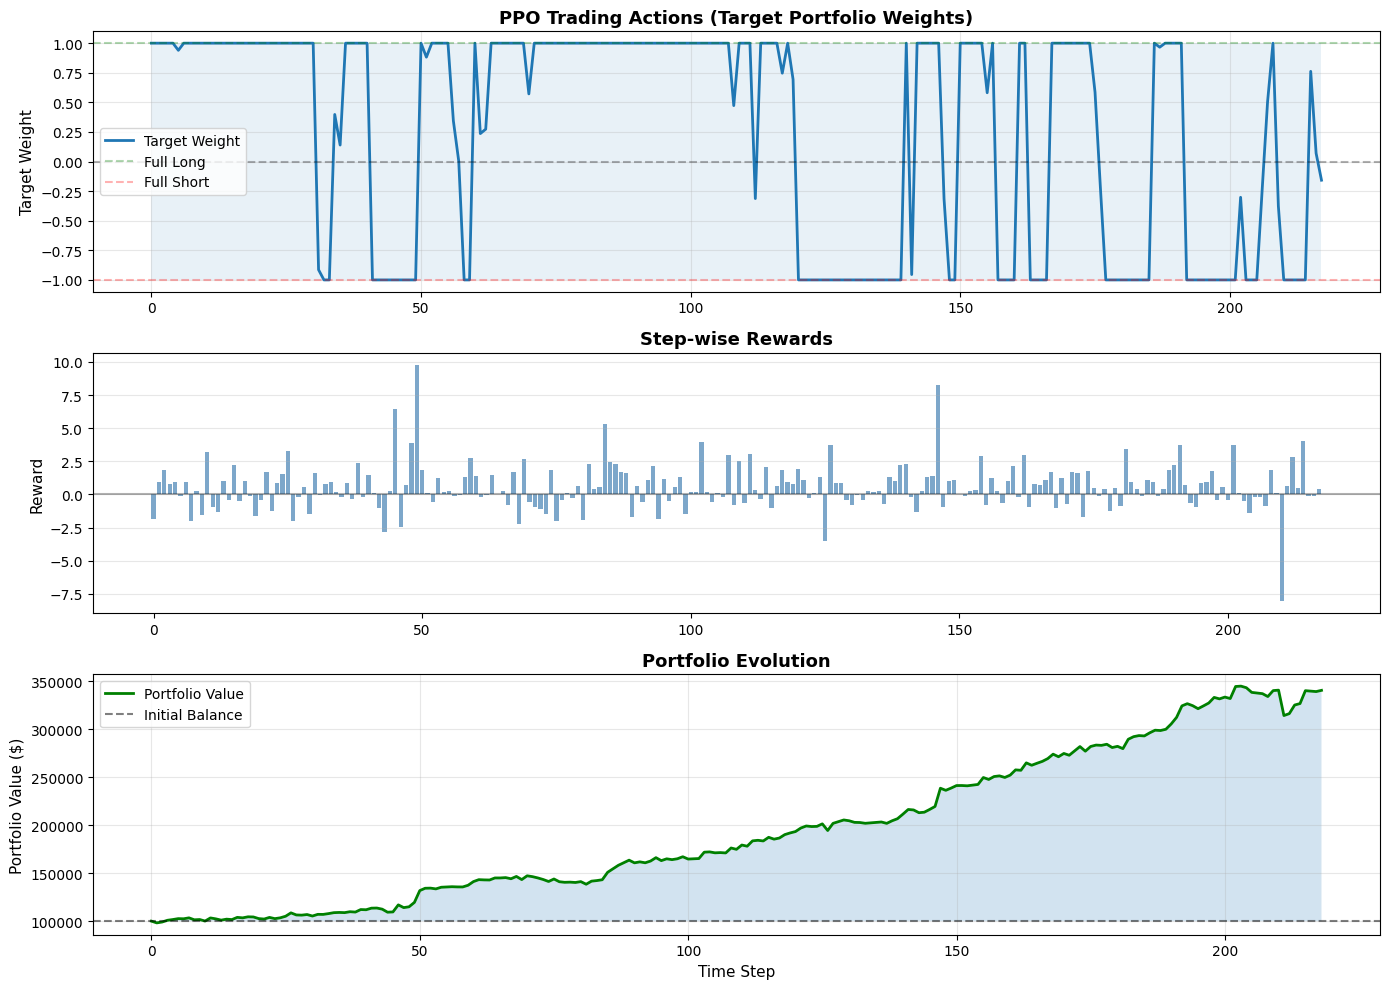


Saving model and artifacts to models/ppo_artifacts...
✓ Saved files: ['feature_scaler.joblib', 'rl_results_summary.json']

Running Walk-Forward Evaluation...


Fold 1 failed: index 60 is out of bounds for axis 0 with size 50
Fold 2 failed: index 60 is out of bounds for axis 0 with size 50
Fold 3 failed: index 60 is out of bounds for axis 0 with size 50
Fold 4 failed: index 60 is out of bounds for axis 0 with size 50
Fold 5 failed: index 60 is out of bounds for axis 0 with size 50
Fold 6 failed: index 60 is out of bounds for axis 0 with size 50
Fold 7 failed: index 60 is out of bounds for axis 0 with size 50
Fold 8 failed: index 60 is out of bounds for axis 0 with size 50
Fold 9 failed: index 60 is out of bounds for axis 0 with size 50
Fold 10 failed: index 60 is out of bounds for axis 0 with size 50
Fold 11 failed: index 60 is out of bounds for axis 0 with size 50
Fold 12 failed: index 60 is out of bounds for axis 0 with size 50


In [ ]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.models.model_trainer_rl_v3 import ModelTrainerRL, TradingEnvRL
from src.utils.config_loader import load_config

# ============================================================================
# CELL 1: Load Configuration
# ============================================================================
config = load_config("config/config.yaml")
print("Config loaded successfully")
print(f"RL Config: {config['reinforcement_learning']}")

# ============================================================================
# CELL 2: Load and Prepare Data
# ============================================================================
data = pd.read_csv('data/processed/CWCO_processed_2022.csv')
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

print(f"Data shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")
print(f"Date range: {data.index.min()} to {data.index.max()}")

# ============================================================================
# CELL 3: Split Train/Test
# ============================================================================
split_idx = int(len(data) * 0.7)
df_train = data.iloc[:split_idx].copy()
df_test = data.iloc[split_idx:].copy()

print(f"Train set: {len(df_train)} days ({df_train.index[0]} to {df_train.index[-1]})")
print(f"Test set: {len(df_test)} days ({df_test.index[0]} to {df_test.index[-1]})")

# ============================================================================
# CELL 4: Initialize Trainer & Prepare Environments
# ============================================================================
trainer = ModelTrainerRL(config['reinforcement_learning'])

# Prepare environments (handles feature scaling automatically)
env_train, env_test = trainer.prepare_environment(
    df_train, 
    df_test, 
    reward_func="profit"  # Options: "profit", "sharpe", "sortino", "cvar", "max_drawdown"
)

print(f"Training env observation space: {env_train.observation_space}")
print(f"Training env action space: {env_train.action_space}")
print(f"Scaler fitted: {trainer.scaler is not None}")

# ============================================================================
# CELL 5: Train PPO Agent
# ============================================================================
print("Training PPO Agent...")
result = trainer.train_ppo(env_train)
model = result["model"]
print("✓ Training Complete!")

# ============================================================================
# CELL 6: Evaluate with Multiple Seeds
# ============================================================================
seeds = [42, 43, 44]
print(f"Running evaluation across {len(seeds)} seeds...")
metrics_agg = trainer.evaluate_over_seeds(model, env_test, seeds, algorithm="PPO")

print("\n" + "="*60)
print("MULTI-SEED EVALUATION RESULTS")
print("="*60)
print(f"Total Return:  {metrics_agg['total_return']['mean']:>8.2%} ± {metrics_agg['total_return']['ci95']}")
print(f"Sharpe Ratio:  {metrics_agg['sharpe_ratio']['mean']:>8.3f} ± {metrics_agg['sharpe_ratio']['ci95']}")
print(f"Sortino Ratio: {metrics_agg['sortino_ratio']['mean']:>8.3f} ± {metrics_agg['sortino_ratio']['ci95']}")
print(f"Max Drawdown:  {metrics_agg['max_drawdown']['mean']:>8.2%} ± {metrics_agg['max_drawdown']['ci95']}")
print("="*60)

# ============================================================================
# CELL 7: Single-Run Evaluation (Deterministic)
# ============================================================================
print("\nSingle Run Evaluation (Seed=42)...")
metrics_single = trainer.evaluate_model(model, env_test, algorithm="PPO", seed=42)

print("\n" + "="*60)
print("SINGLE RUN EVALUATION")
print("="*60)
print(f"Total Return:  {metrics_single['total_return']:.2%}")
print(f"Final Value:   ${metrics_single['final_value']:,.2f}")
print(f"Sharpe Ratio:  {metrics_single['sharpe_ratio']:.3f}")
print(f"Sortino Ratio: {metrics_single['sortino_ratio']:.3f}")
print(f"Max Drawdown:  {metrics_single['max_drawdown']:.2%}")
print(f"Avg Reward:    {metrics_single['avg_reward']:.4f}")
print("="*60)

# ============================================================================
# CELL 8: Generate Trading Actions (Inference)
# ============================================================================
print("\nGenerating trading actions on test set...")
obs, _ = env_test.reset(seed=42)
done = False
actions = []
episode_rewards = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    actions.append(float(action[0]))
    obs, reward, terminated, truncated, info = env_test.step(action)
    episode_rewards.append(float(reward))
    done = terminated or truncated

print(f"✓ Generated {len(actions)} trading actions")
print(f"Action range: [{np.min(actions):.3f}, {np.max(actions):.3f}]")
print(f"Action mean: {np.mean(actions):.3f}")
print(f"Actions breakdown:")
print(f"  Long (>0.5):  {sum(np.array(actions) > 0.5)}")
print(f"  Neutral (-0.5 to 0.5): {sum((np.array(actions) >= -0.5) & (np.array(actions) <= 0.5))}")
print(f"  Short (<-0.5): {sum(np.array(actions) < -0.5)}")

# ============================================================================
# CELL 9: Visualize Actions and Rewards
# ============================================================================
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Trading Actions Over Time
axes[0].plot(actions, label='Target Weight', linewidth=2)
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].axhline(y=1, color='g', linestyle='--', alpha=0.3, label='Full Long')
axes[0].axhline(y=-1, color='r', linestyle='--', alpha=0.3, label='Full Short')
axes[0].fill_between(range(len(actions)), -1, 1, alpha=0.1)
axes[0].set_ylabel('Target Weight', fontsize=11)
axes[0].set_title('PPO Trading Actions (Target Portfolio Weights)', fontsize=13, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Episode Rewards
axes[1].bar(range(len(episode_rewards)), episode_rewards, alpha=0.7, color='steelblue')
axes[1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1].set_ylabel('Reward', fontsize=11)
axes[1].set_title('Step-wise Rewards', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Cumulative Portfolio Value
portfolio_vals = env_test.portfolio_values
axes[2].plot(portfolio_vals, linewidth=2, label='Portfolio Value', color='green')
axes[2].axhline(y=env_test.initial_balance, color='k', linestyle='--', alpha=0.5, label='Initial Balance')
axes[2].fill_between(range(len(portfolio_vals)), env_test.initial_balance, portfolio_vals, alpha=0.2)
axes[2].set_xlabel('Time Step', fontsize=11)
axes[2].set_ylabel('Portfolio Value ($)', fontsize=11)
axes[2].set_title('Portfolio Evolution', fontsize=13, fontweight='bold')
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# CELL 10: Save Model & Artifacts
# ============================================================================
save_path = "models/ppo_artifacts"
print(f"\nSaving model and artifacts to {save_path}...")
trainer.save_models(save_path)

# Verify saved files
import os
saved_files = os.listdir(save_path)
print(f"✓ Saved files: {saved_files}")

# ============================================================================
# CELL 11: (OPTIONAL) Walk-Forward Evaluation
# ============================================================================
print("\nRunning Walk-Forward Evaluation...")
wf_results = trainer.walk_forward_evaluation(
    data,
    window_size=200,
    step_size=50,
    reward_func="profit",
    algorithm="ppo",
    seeds=[42, 43, 44],
)

print(f"Walk-forward folds: {len(wf_results['fold_results'])}")
print(f"\nAggregate Walk-Forward Results:")
agg = wf_results['aggregate']
print(f"  Sharpe Ratio: {agg['sharpe_ratio']['mean']:.3f} ± {agg['sharpe_ratio']['ci95']}")
print(f"  Total Return: {agg['total_return']['mean']:.2%} ± {agg['total_return']['ci95']}")
print(f"  Max Drawdown: {agg['max_drawdown']['mean']:.2%} ± {agg['max_drawdown']['ci95']}")

# ============================================================================
# CELL 12: (OPTIONAL) Reload & Use Saved Model Later
# ============================================================================
print("\nReloading saved model for inference...")
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecNormalize
import joblib

# Load artifacts
loaded_model = PPO.load(f"{save_path}/ppo_model")
loaded_scaler = joblib.load(f"{save_path}/feature_scaler.joblib")
loaded_vecnorm = VecNormalize.load(f"{save_path}/ppo_vecnormalize.pkl")

print("✓ Model, scaler, and VecNormalize loaded successfully")

# Use loaded model on new data (example)
obs_new, _ = env_test.reset(seed=42)
action_new, _ = loaded_model.predict(obs_new, deterministic=True)
print(f"Loaded model predicts action: {action_new[0]:.3f}")